In [1]:
from wovenv.ai.q_learning import QLearningAgent
from wovenv.venv.env import Env
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import torch

# Окружение и агент

In [2]:
env = Env()
agent = QLearningAgent(alpha=0.5, discount=0.9)

In [3]:
def generate_session(env: Env, agent: QLearningAgent, t_max=1000, train=False):
    env.write_log = not train
    total_reward = 0
    s = env.reset()

    game = []

    for t in range(t_max):
        a = agent.get_action(s)
        next_s, r, done = env.step(a)

        game.append((s, a, next_s, r, done))

        total_reward += r
        s = next_s

        if done:
            if not train: env.finish_log()
            break
            
    loss = None
    if train:
        for s, a, next_s, r, done in game:
            agent.update(s, a, next_s, r, done)
        loss = agent.update_batch()

    return total_reward, loss, s

# Визуализация

In [4]:
def plot(rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('reward: %s' % (np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss: %s' % (np.mean(losses[-10:])))
    plt.plot(losses)
    plt.show()

# Горячий старт (при необходимости)

In [5]:
def hot_start(env: Env, agent: QLearningAgent, ind, t_max=1000):
    clear_output()
    print(f'start {ind}')
    s = env.reset()

    for t in range(t_max):
        acs = env._get_actions()
        for a in acs:
            next_s, r, done = env.step(a)
            agent.update(s, a, next_s, r, done)
            s = next_s
            if done: return

In [6]:
#for i in range(1000):
#    hot_start(env, agent, i)

# Обучение

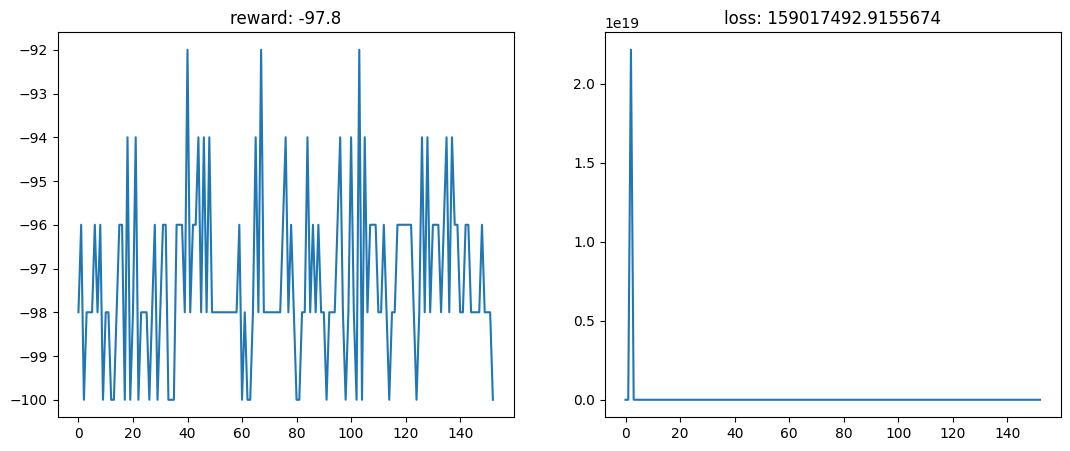

In [7]:
rewards, losses = [], []
learning_rate = 1

torch.backends.cudnn.benchmark = True

while True:
    agent.set_lr(learning_rate)
    reward, loss, _ = generate_session(env,agent,train=True)
    rewards.append(reward)
    losses.append(loss)
    agent.epsilon *= 0.99
    learning_rate *= 0.99
    if agent.epsilon < 0.05:
        agent.epsilon = 0.5
    if learning_rate < 0.05:
        learning_rate = 0.4
    plot(rewards, losses)

# Сериализация

In [ ]:
import pickle

---
### Сохранение обученного агента

In [ ]:
with open('data.pickle', "wb") as f:
    pickle.dump(agent, f)

---
### Загрузка сохраненного агента

In [ ]:
agent = pickle.load(open('data.pickle', 'rb'))

# Генерация игры с записью в лог для последующей визуализации

In [ ]:
agent.epsilon = 0
_, __, s = generate_session(env, agent)